# SARIMAX 모델을 이용한 일별 영화수요 예측

In [1]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd 

import os
import warnings

import holidays

import matplotlib.pyplot as plt
theme_color = '#8B0000'
from matplotlib.collections import PolyCollection

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from time import time
from tqdm import tqdm

In [2]:
# 데이터 불러오기
data = pd.read_parquet('kofic_data/kofic_data.parquet')
data.head()

,date,rank,movieCd,movieNm,openDt,salesAmt,salesShare,salesInten,salesChange,salesAcc,audiCnt,audiInten,audiChange,audiAcc,scrnCnt,showCnt
0,20160101,1,20136068,히말라야,2015-12-16,4529795647,38.3,2303664641,103.5,43999571095,554307,259690,88.1,5683716,955,4678
1,20160101,10,20156807,뽀로로 극장판 컴퓨터 왕국 대모험,2015-12-10,96435100,0.8,27436400,39.8,2998525700,12243,2749,29,404003,151,245
2,20160101,2,20150025,내부자들: 디 오리지널,2015-12-31,2092539355,17.7,864281640,70.4,3329327070,247992,88926,55.9,408140,822,2088
3,20160101,3,20154141,스타워즈: 깨어난 포스,2015-12-17,1400855545,11.9,603603060,75.7,25550334085,154446,59442,62.6,2957680,552,2067
4,20160101,4,20144442,조선마술사,2015-12-30,1153061953,9.8,387563159,50.6,2659511747,145065,40336,38.5,369722,608,2319


## 0. 데이터 전처리

### 데이터 전처리 - 데이터 타입 변환

In [3]:
# 날짜 데이터를 datetime 형식으로 변환
data['date'] = pd.to_datetime(data['date'])

# 관객수 데이터를 정수형으로 변환
data['audiCnt'] = data['audiCnt'].astype(int)

### 데이터 전처리 - 일별 총 관객수 계산

KOFIC에서 받은 일별 박스오피스 데이터에는 상위 10개 영화 데이터 밖에 존재하지 않습니다.

일자별 상위 10개 영화들의 총 관객수를 합산해, 해당 날짜의 모든 영화 관객수에 대한 매개 변수로 사용하였습니다. 

In [4]:
# 일별 상위 10개 영화의 관객수의 총합
data['totalAudi'] = data.groupby('date')['audiCnt'].transform('sum')

In [5]:
# 데이터 타입 확인
data[['date', 'totalAudi']].dtypes

date         datetime64[ns]
totalAudi             int32
dtype: object

In [6]:
data[['date', 'totalAudi']].drop_duplicates()

,date,totalAudi
0,2016-01-01,1399765
10,2016-01-02,1422829
20,2016-01-03,1031060
30,2016-01-04,389120
40,2016-01-05,346976
...,...,...
13040,2019-07-27,974497
13050,2019-07-28,882066
13060,2019-07-29,467377
13070,2019-07-30,470214


---

## 1. 시계열 데이터 특성 분석

In [7]:
# 시계열 분석을 위해 데이터 추출
total_movie_watchers = data[['date', 'totalAudi']].drop_duplicates()

# 날짜를 인덱스로 설정
total_movie_watchers.set_index('date', inplace=True)

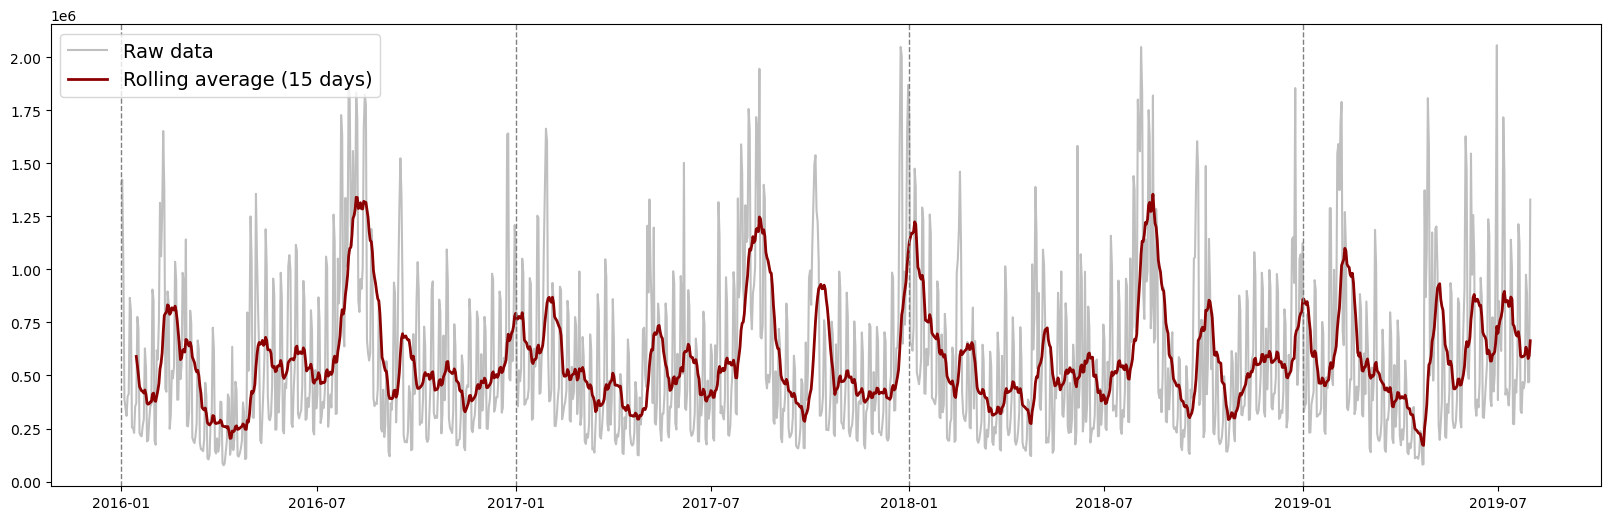

In [8]:
# 총 영화 관객수 시계열 그래프
plt.figure(figsize=(20, 6))
plt.plot(total_movie_watchers, color='gray', alpha=0.5)

# 15일 이동평균을 빨간색으로 표시
plt.plot(total_movie_watchers.rolling(window=15).mean(), color=theme_color, linewidth=2)

# 연도 구분용 선 추가
for year in range(2016, 2020):
    plt.axvline(x=pd.to_datetime(f'{year}-01-01'), color='gray', linestyle='--', linewidth=1)

plt.legend(['Raw data', 'Rolling average (15 days)'], fontsize=14, loc='upper left')
plt.show()

### a. 데이터가 안정적(stationary)인지 확인


In [9]:
# Augmented Dickey-Fuller 테스트 함수
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

# 데이터가 안정적인지 확인
perform_adf_test(total_movie_watchers['totalAudi'])

ADF Statistic: -6.665791
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


데이터의 평균과 분포가 시간에 따라 유의미한 영향을 받지 않는다는 것을 확인했습니다.

### b. ACF + PACF

In [10]:
# 시각화 customization을 위한 keyword arguments 설정
kwargs_acf = {'color': '#8B0000',
              'vlines_kwargs': {'colors': '#8B0000', 'linestyle': '--'}}

kwargs_pacf = {'vlines_kwargs': {'linestyle': '--'}}

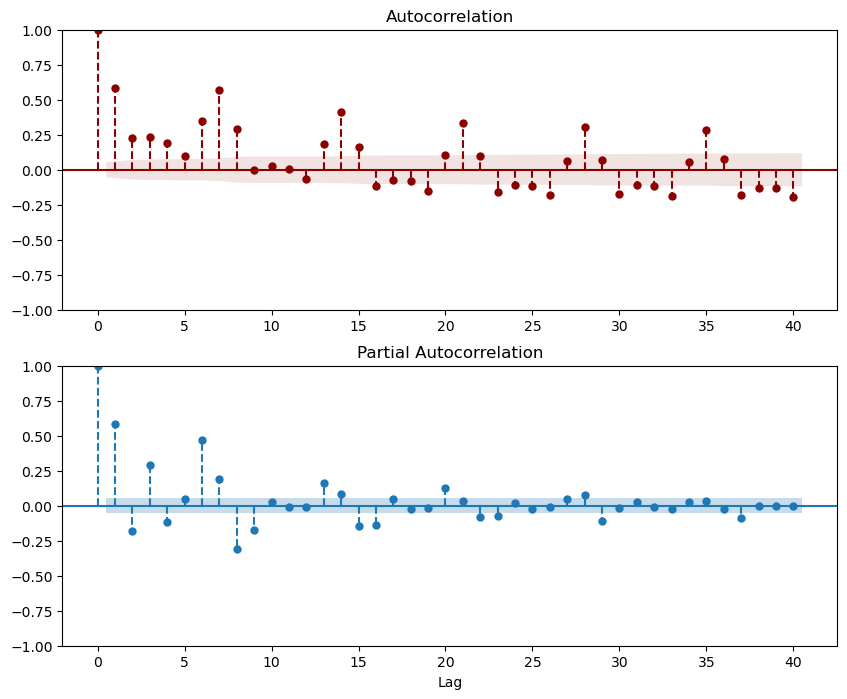

In [11]:
# ACF, PACF 그래프
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(total_movie_watchers.values, lags=40, ax=ax[0], **kwargs_acf);
for item in ax[0].collections:
    if type(item) == PolyCollection:
        item.set_facecolor('#CE9393')
plot_pacf(total_movie_watchers, lags=40, ax=ax[1], **kwargs_pacf);
ax[1].set_xlabel('Lag')
plt.show()

가장 특징적으로 보이는 lag가 매 7일 (주) 단위 lag입니다. 이를 고려해 계절성을 차분하여 제거해 주도록 하겠습니다.

### c. 계절성 (주 단위) 제거

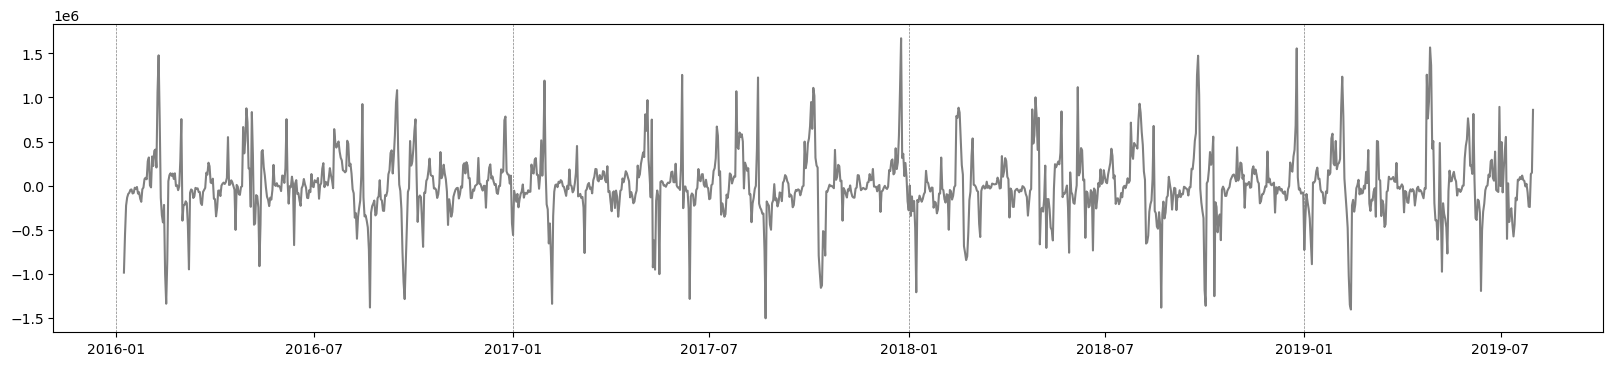

In [12]:
# 계절성을 제거하기 위해 7일 간격으로 차분
total_movie_watchers_diff_7 = total_movie_watchers.diff(7).dropna()

# 차분 후 데이터 시각화
plt.figure(figsize=(20, 4))
plt.plot(total_movie_watchers_diff_7, color='gray')
for year in range(2016, 2020):
    plt.axvline(x=pd.to_datetime(f'{year}-01-01'), color='gray', linestyle='--', linewidth=0.5)
plt.show()

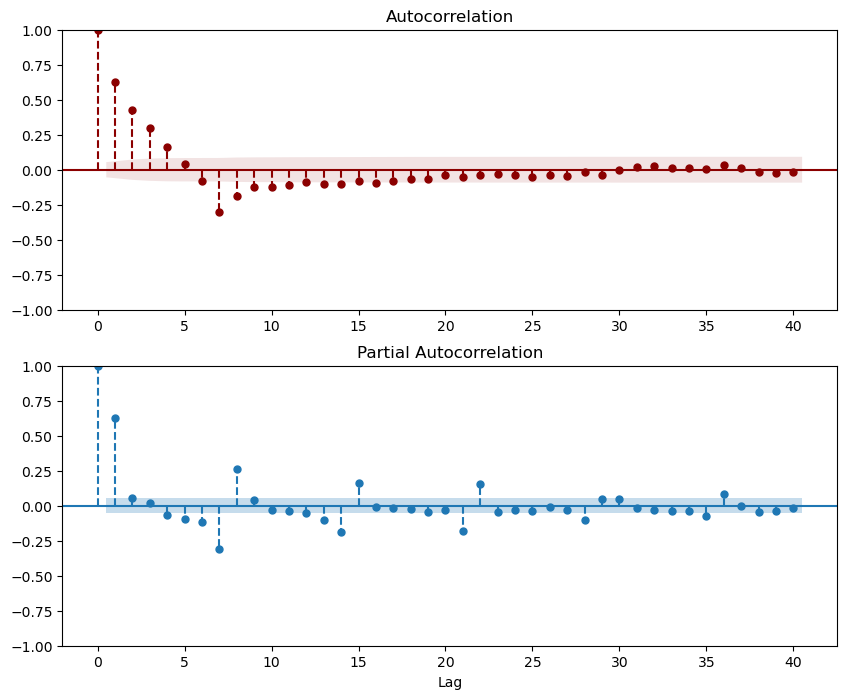

In [13]:
# ACF, PACF 그래프
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(total_movie_watchers_diff_7.values, lags=40, ax=ax[0], **kwargs_acf);
for item in ax[0].collections:
    if type(item) == PolyCollection:
        item.set_facecolor('#CE9393')
plot_pacf(total_movie_watchers_diff_7, lags=40, ax=ax[1], **kwargs_pacf);
ax[1].set_xlabel('Lag')
plt.show()

7일 간격으로 차분을 한 데이터의 ACF와 PACF에서 7일차 관객수의 상관관계를 더 도드라지게 볼 수 있습니다.

### d. 외생변수 정의

In [14]:
# 외생변수 정의 (공휴일 여부, 연도)
exog = pd.DataFrame(index=total_movie_watchers.index)

# 공휴일 여부
kr_holidays = holidays.Korea(years=range(2016, 2020))
exog['is_holiday'] = exog.index.map(lambda x: x in kr_holidays).astype(int)

# Fourier Series 외생변수 추가 (연도별 계절성)
exog['sin_365_1'] = np.sin(2 * np.pi * exog.index.dayofyear / 365)
exog['cos_365_1'] = np.cos(2 * np.pi * exog.index.dayofyear / 365)
exog['sin_365_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 365)
exog['cos_365_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 365)

## 2. SARIMAX 모델 구축

### 학습 / 테스트 데이터 분할

In [15]:
# 학습 및 테스트 날짜 설정
train_start_date = '2016-09-20'
train_end_date = '2018-12-20'
len_forecast = 7
first_forecast_date = str(pd.to_datetime(train_end_date) + pd.DateOffset(days=1))[:10]
final_forecast_date = str(pd.to_datetime(train_end_date) + pd.DateOffset(days=len_forecast))[:10]

train = total_movie_watchers[train_start_date:train_end_date]
test = total_movie_watchers[first_forecast_date:final_forecast_date]
exog_train = exog[train_start_date:train_end_date]
exog_test = exog[first_forecast_date:final_forecast_date]

print(f"Training set: {train.index[0]} to {train.index[-1]}")
print(f"Testing set: {test.index[0]} to {test.index[-1]}")

Training set: 2016-09-20 00:00:00 to 2018-12-20 00:00:00
Testing set: 2018-12-21 00:00:00 to 2018-12-27 00:00:00


In [16]:
# 학습데이터 안정성 확인
perform_adf_test(train['totalAudi'])

ADF Statistic: -5.030004
p-value: 0.000019
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


### 모델 1: SARIMA(1, 0, 1)(0, 0, 0)_7
단순 AR(1), MA(1) 모델 적용

In [17]:
# ARIMA 모델 생성
order = (1, 0, 1)
seasonal_order = (0, 0, 0, 7)

model_1 = SARIMAX(endog=train['totalAudi'], order=order, seasonal_order=seasonal_order)

start = time()
model_1_fit = model_1.fit()
end = time()  
print(f"Model fitting took {end - start:.2f} seconds.")

Model fitting took 0.13 seconds.


c:\Users\YuHan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\YuHan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              totalAudi   No. Observations:                  822
Model:               SARIMAX(1, 0, 1)   Log Likelihood              -11615.973
Date:                Fri, 13 Dec 2024   AIC                          23237.946
Time:                        14:35:14   BIC                          23252.081
Sample:                    09-20-2016   HQIC                         23243.369
                         - 12-20-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9817      0.007    144.048      0.000       0.968       0.995
ma.L1         -0.6511      0.026    -25.011      0.000      -0.702      -0.600
sigma2      1.115e+11   3.12e-14   3.58e+24      0.0

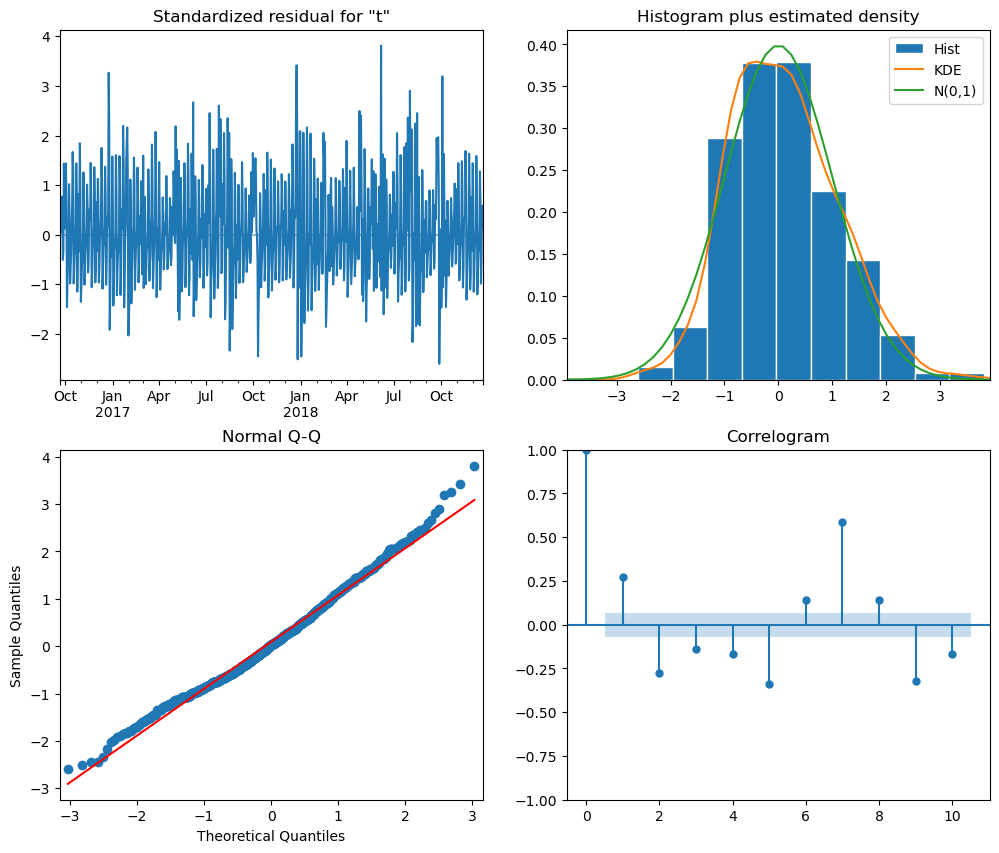

In [18]:
print(model_1_fit.summary())
model_1_fit.plot_diagnostics(figsize=(12, 10))
plt.show()

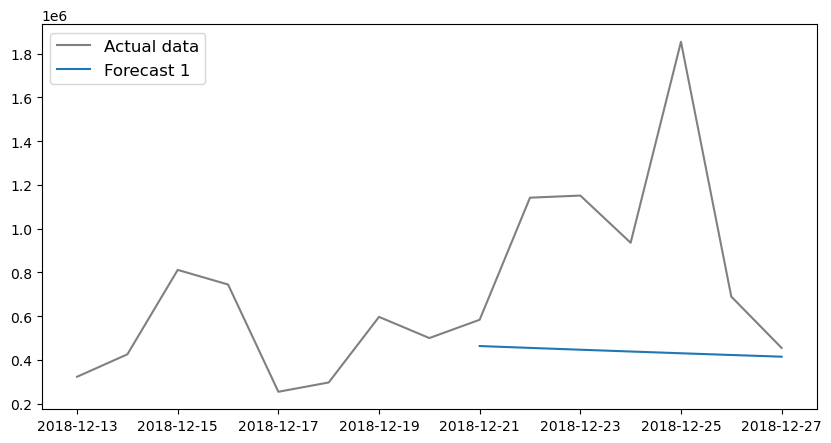

In [19]:
# 모델 사용해서 예측
forecast_1 = model_1_fit.forecast(len(test))
forecast_1.index = test.index

# 예측 결과 시각화
plt.figure(figsize=(10, 5))
# 학습데이터 일주일 및 예측 데이터 일주일 시각화
end_date = final_forecast_date 
start_date = str(pd.to_datetime(end_date) - pd.DateOffset(days=len(test)+7))[:10]
plt.plot(total_movie_watchers[start_date:end_date], color='gray', label='Actual data', linestyle='-')
plt.plot(forecast_1, label='Forecast 1')
plt.legend(fontsize=12)
plt.show()

### 모델 2: SARIMA(1, 0, 1)(1, 1, 1)_7
- 주별 계절성 추가

In [20]:
# ARIMA 모델 생성
order = (1, 0, 1)
seasonal_order = (1, 1, 1, 7)

model_2 = SARIMAX(train['totalAudi'], order=order, seasonal_order=seasonal_order)

start = time()
model_2_fit = model_2.fit()
end = time()
print(f"Model fitting took {end - start:.2f} seconds.")

c:\Users\YuHan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\YuHan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Model fitting took 1.22 seconds.


                                     SARIMAX Results                                     
Dep. Variable:                         totalAudi   No. Observations:                  822
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 7)   Log Likelihood              -11191.353
Date:                           Fri, 13 Dec 2024   AIC                          22392.707
Time:                                   14:35:17   BIC                          22416.223
Sample:                               09-20-2016   HQIC                         22401.733
                                    - 12-20-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8194      0.037     22.384      0.000       0.748       0.891
ma.L1         -0.2274      0.059     -3.827

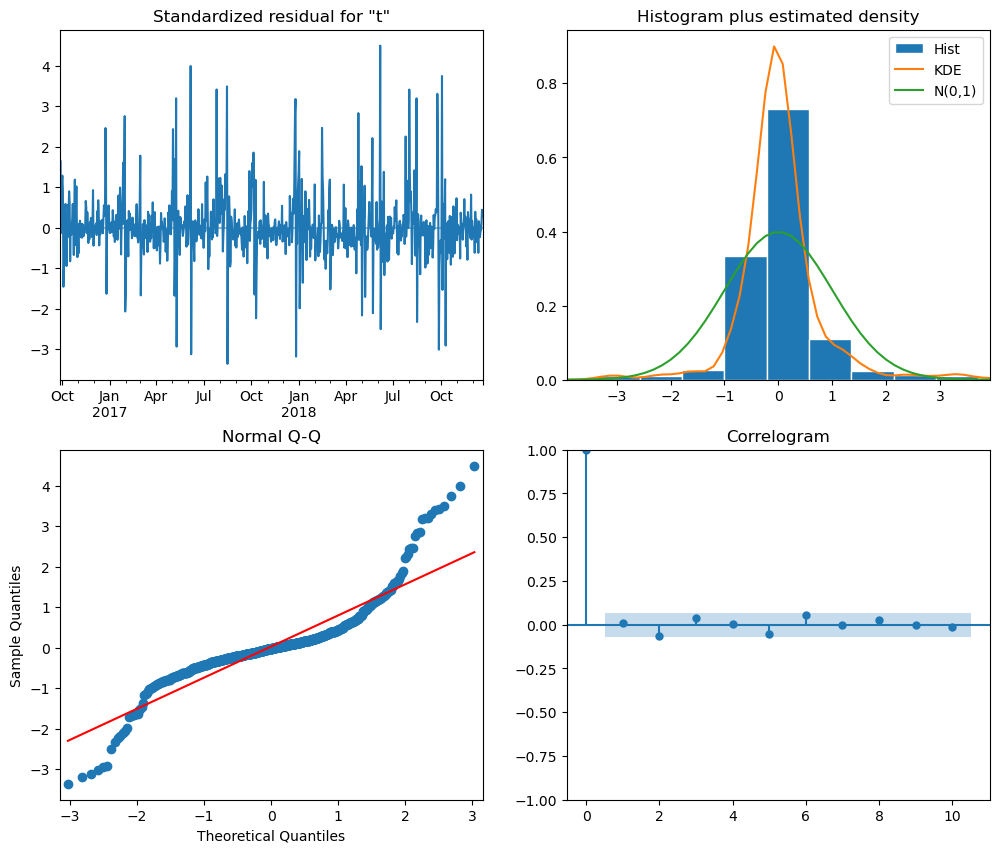

In [21]:
print(model_2_fit.summary())
model_2_fit.plot_diagnostics(figsize=(12, 10))
plt.show()

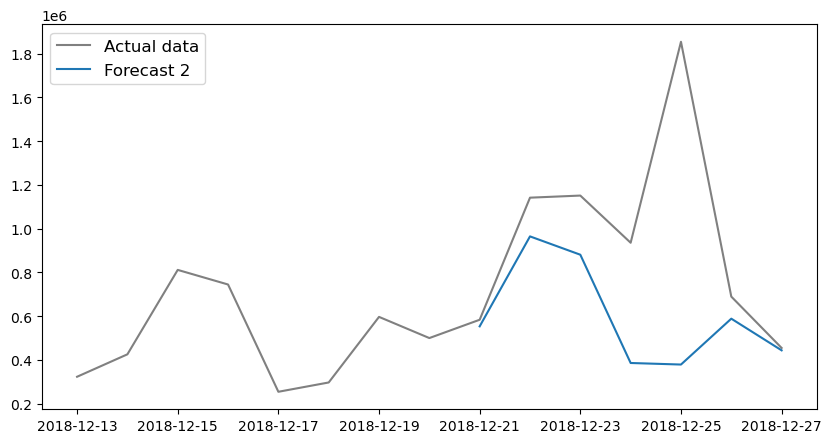

In [22]:
# 모델 사용해서 예측
forecast_2 = model_2_fit.forecast(len(test))
forecast_2.index = test.index

# 예측 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(total_movie_watchers[start_date:end_date], color='gray', label='Actual data', linestyle='-')
plt.plot(forecast_2, label='Forecast 2')
plt.legend(fontsize=12)
plt.show()

### 모델 3: SARIMAX(1, 0, 1)(1, 1, 1)_7 with Holiday and Yearly Seasonality
- 외생성 변수로 연도별 계절성 및 공휴일 고려

In [23]:
# ARIMA 모델 생성
order = (1, 0, 1)
seasonal_order = (1, 1, 1, 7)

model_3 = SARIMAX(train['totalAudi'], exog=exog_train, 
                  order=order, seasonal_order=seasonal_order, enforce_invertibility=False)

start = time()
model_3_fit = model_3.fit()
end = time()
print(f"Model fitting took {end - start:.2f} seconds.")

c:\Users\YuHan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\YuHan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Model fitting took 2.34 seconds.


                                     SARIMAX Results                                     
Dep. Variable:                         totalAudi   No. Observations:                  822
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 7)   Log Likelihood              -10979.881
Date:                           Fri, 13 Dec 2024   AIC                          21979.762
Time:                                   14:35:20   BIC                          22026.794
Sample:                               09-20-2016   HQIC                         21997.814
                                    - 12-20-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
is_holiday  8.097e+05   2.32e+04     34.918      0.000    7.64e+05    8.55e+05
sin_365_1   -7.46e+04   7.43e+04     -1.004

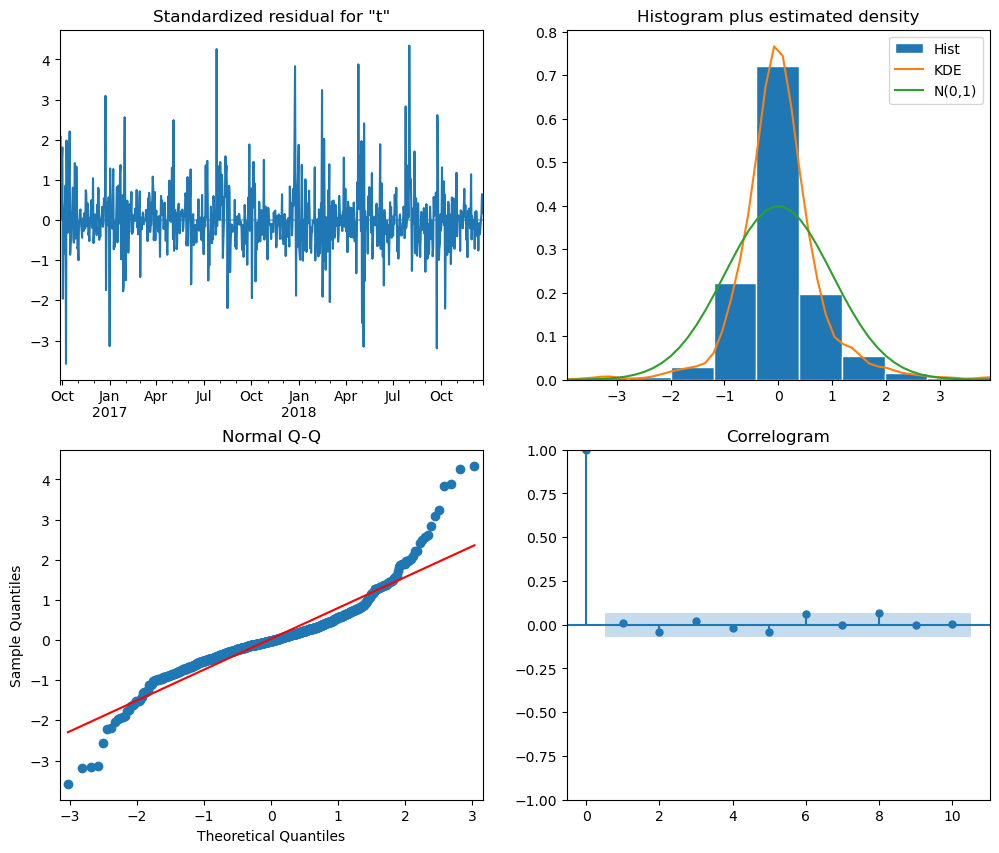

In [24]:
print(model_3_fit.summary())
model_3_fit.plot_diagnostics(figsize=(12, 10))
plt.show()

In [25]:
# 모델 사용해서 예측
forecast_3 = model_3_fit.forecast(len(test), exog=exog_test)
forecast_3.index = test.index

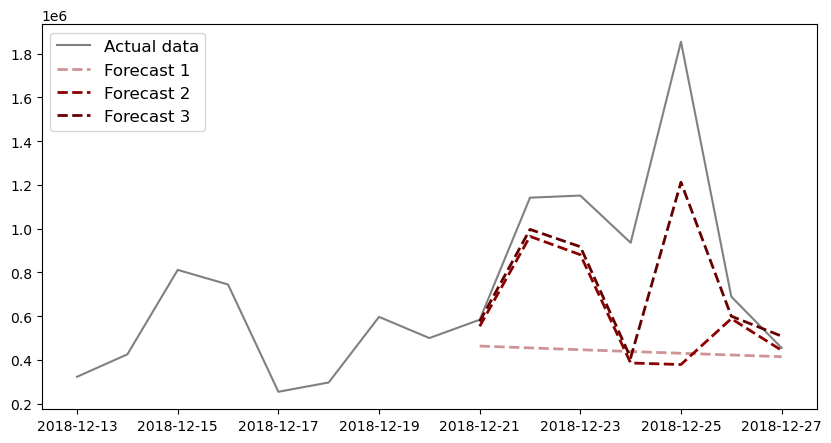

In [26]:
# 3개 모델 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(total_movie_watchers[start_date:end_date], color='gray', label='Actual data', linestyle='-')
plt.plot(forecast_1, label='Forecast 1', color='#CE9393', linestyle='--', linewidth=2)
plt.plot(forecast_2, label='Forecast 2', color='#8B0000', linestyle='--', linewidth=2)
plt.plot(forecast_3, label='Forecast 3', color='#660000', linestyle='--', linewidth=2)
plt.legend(fontsize=12)
plt.show()

## 3. 요일별 예측 데이터 생성
 

In [27]:
warnings.filterwarnings('ignore')

# 최소 학습기간을 13개월을 주기 위해 2017년 2월 1일부터 예측을 시작합니다.
start_date = '2017-02-01'
end_date = '2019-07-24'

# 날짜 범위 내에서 일별로 반복
for date in tqdm(pd.date_range(start_date, end_date, freq='D')):
    train_start_date = date - pd.DateOffset(months=13)  # 1년 1개월 전부터 학습
    train_end_date = date
    len_forecast = 7
    first_forecast_date = str(pd.to_datetime(train_end_date) + pd.DateOffset(days=1))[:10]
    final_forecast_date = str(pd.to_datetime(train_end_date) + pd.DateOffset(days=len_forecast))[:10]

    # 학습 및 테스트 데이터 설정
    train = total_movie_watchers[train_start_date:train_end_date]
    test = total_movie_watchers[first_forecast_date:final_forecast_date]
    exog_train = exog[train_start_date:train_end_date]
    exog_test = exog[first_forecast_date:final_forecast_date]

    # SARIMAX 모델 생성 및 학습
    model = SARIMAX(train['totalAudi'], exog=exog_train, 
                    order=(1, 0, 1), seasonal_order=(1, 1, 1, 7), enforce_invertibility=False)
    model_fit = model.fit()

    # 예측 수행
    forecast = model_fit.forecast(len(test), exog=exog_test)

    # 예측 결과 저장
    total_movie_watchers.loc[train_end_date, ['forecast_1', 'forecast_2', 'forecast_3',
                                              'forecast_4', 'forecast_5', 'forecast_6', 'forecast_7']] = forecast.values

100%|██████████| 904/904 [18:50<00:00,  1.25s/it]


In [28]:
# 2019-07-25일 이후 데이터 제거
total_movie_watchers = total_movie_watchers[:-7]

In [29]:
total_movie_watchers.head()

,totalAudi,forecast_1,forecast_2,forecast_3,forecast_4,forecast_5,forecast_6,forecast_7
date,,,,,,,,
2016-01-01,1399765,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-02,1422829,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-03,1031060,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-04,389120,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,346976,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# 컬럼명 변경
total_movie_watchers.rename(columns={'totalAudi': 'actual'}, inplace=True)
temp = total_movie_watchers.copy()


# 인덱스를 다시 'date'로 설정
ts_data_filled = temp.set_index('date')
ts_data_filled.head()

## 4. 시계열 데이터 저장

In [47]:
# 시계열 분석을 위한 데이터 저장
if not os.path.exists('./processed_data'):
    os.makedirs('./processed_data')
ts_data_filled.to_csv('./processed_data/TS_data_n.csv', index=True)